# Generate Computer Vision Data without any images

---------------
In computer vision, effectively handling rare classes is crucial for accurate model performance, especially in applications like biodiversity monitoring and autonomous driving. Techniques such as data augmentation and synthetic data generation can enhance model generalization for these underrepresented classes



#### Tools Used:
- Diffusion Model to generate Images: We'll use Stable Diffusion 3
- Grounding Dino: to generate Detection and Segmentation Data
- Depth Anything v2: to generate depths which can determine the distance of objects from ego-car

#### Load Libraries

In [1]:
import torch
from diffusers import StableDiffusion3Pipeline
import requests
from PIL import Image

import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple
import cv2
import numpy as np
from PIL import Image
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline, AutoModelForZeroShotObjectDetection

#### Load Diffusion Model to generate images using Descriptions

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

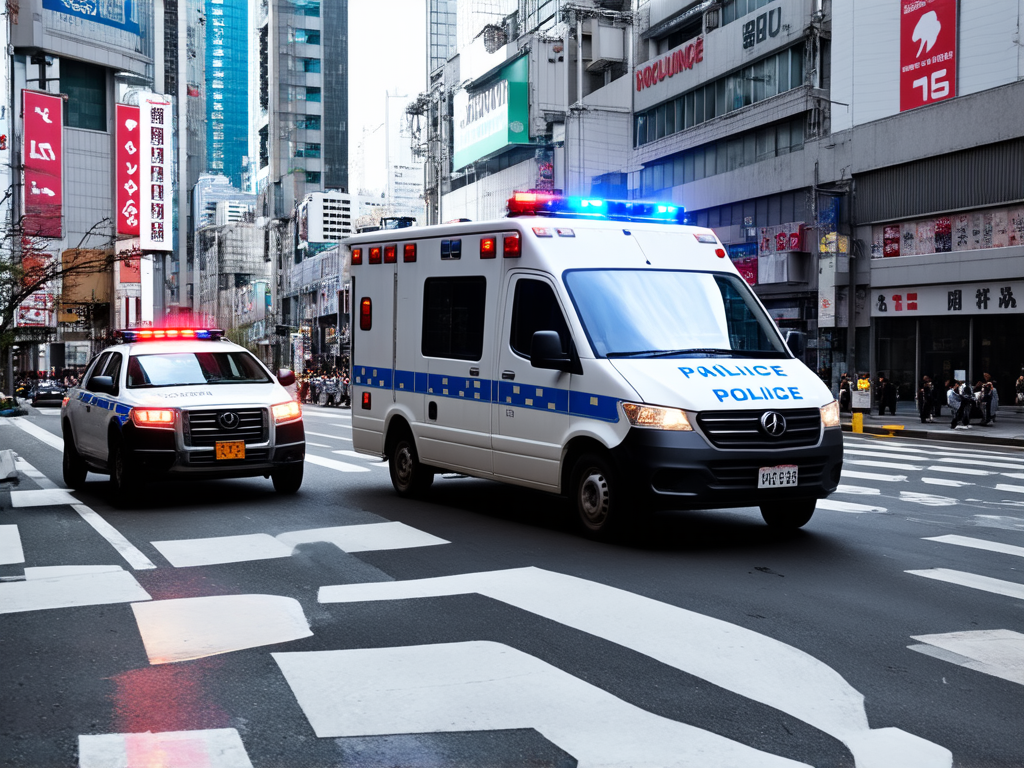

In [5]:
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
def generate_images(pipe, description):
    image = pipe(
        description,
        negative_prompt="",
        height=768,
        width=1024,
        num_inference_steps=28,
        guidance_scale=7.0,
    ).images[0]
    return image
description = 'An Image of Ambulance running on the streets of Tokyo with police car on side'
generated_image = generate_images(pipe, description)
display(generated_image)

#### Observations

- In the above image, which is Diffusion model generated is completely based on the description

#### Load the grounding dino model to generate the detections on the above image

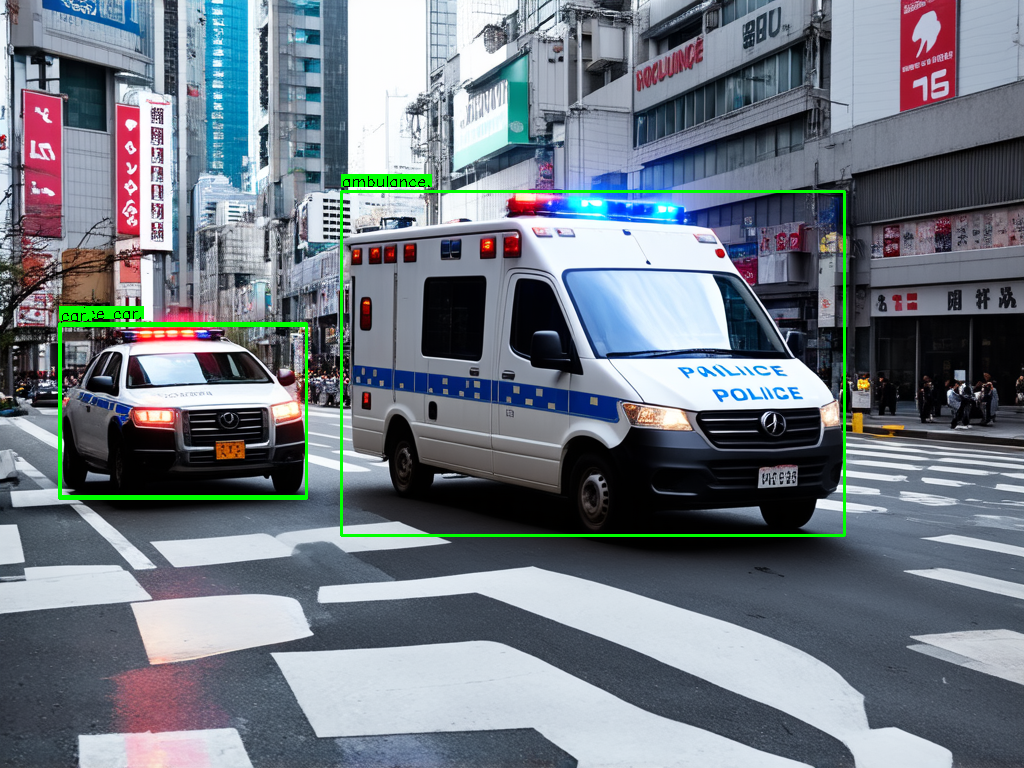

In [6]:
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
model_id = "IDEA-Research/grounding-dino-base"
device = "cuda"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)


# Check for cats and remote controls
text = ["ambulance.", "car.", "police car.", "sky.", "building."]

def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.5,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    #results = [DetectionResult.from_dict(result) for result in results]
    all_bboxes = []
    all_labels = []
    for bbox in results:
        temp_box = [bbox['box']['xmin'], bbox['box']['ymin'], bbox['box']['xmax'], bbox['box']['ymax']]
        temp_label = bbox['label']
        all_bboxes.append(temp_box)
        all_labels.append(temp_label)
    return all_bboxes, all_labels


def visualize_detector(image, boxes, labels):
    """
    Merge detections from patches and draw bounding boxes on the original image.

    Args:
        image (PIL image): Original image.
        detections (list): List of detections for each patch.
        positions (list): List of top-left corner coordinates for each patch.
        patch_size (int): Size of each patch.

    Returns:
        PIL Image: Image with drawn bounding boxes and labels.
    """
    image = np.array(image)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    #semantic_array = np.array(Image.open(semantic_mask))
    for box, label in zip(boxes, labels):
        # Adjust box coordinates to the original image
        x1, y1, x2, y2 = box

        # Draw bounding box
        cv2.rectangle(
            image,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color=(0, 255, 0),
            thickness=2,
        )

        # Put label and score
        label_text = f"{label}"
        text_size = cv2.getTextSize(label_text, font, font_scale, thickness)[0]
        text_x = int(x1)
        text_y = int(y1) - 5
        if text_y < 0:  # Ensure text doesn't go out of bounds
            text_y = int(y1) + text_size[1] + 5
        cv2.rectangle(
            image,
            (text_x, text_y - text_size[1]),
            (text_x + text_size[0], text_y),
            (0, 255, 0),
            -1,
        )
        cv2.putText(
            image,
            label_text,
            (text_x, text_y),
            font,
            font_scale,
            (0, 0, 0),
            thickness,
        )
    return Image.fromarray(image)


boxes, labels = detect(generated_image, text, detector_id = "IDEA-Research/grounding-dino-tiny")
image_bbox = visualize_detector(generated_image, boxes, labels)
display(image_bbox)

#### Load the SAM to generate Segmentation Data

In [7]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image


def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

def segment(
    image: Image.Image,
    boxes: List[List[float]],
    labels:  List[str],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
):
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    # for detection_result, mask in zip(detection_results, masks):
    #     detection_result.mask = mask

    return masks


masks = segment(generated_image, [boxes], labels, True)

#### Let's Visualize all masks generated from SAM

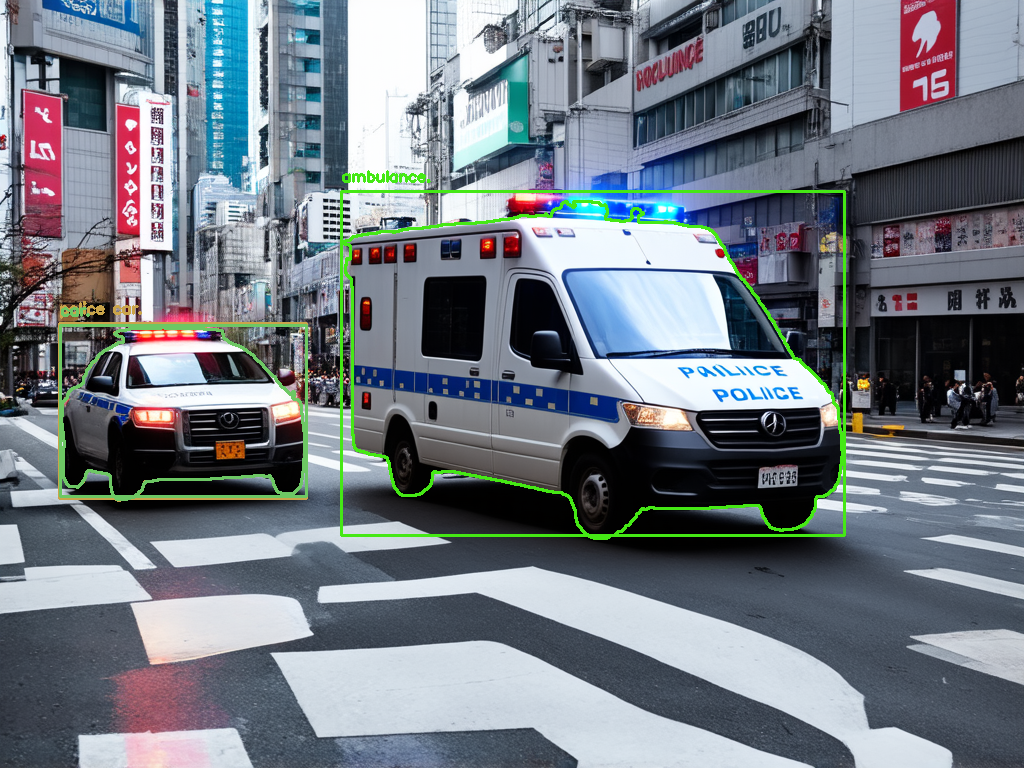

In [10]:
def annotate(image: Image.Image, boxes, masks, labels) -> Image.Image:
    # Convert PIL Image to OpenCV format
    image_array = np.array(image) if isinstance(image, Image.Image) else image

    # Iterate over detections and add bounding boxes and masks
    for box, (mask, label) in zip(boxes, zip(masks, labels)):
        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_array, (box[0], box[1]), (box[2], box[3]), color.tolist(), 2)
        cv2.putText(image_array, f'{label}', (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_array, contours, -1, color.tolist(), 2)

    return Image.fromarray(image_array)
annotate(generated_image, boxes, masks, labels)

#### Results

- Here, we are succesfully able to generate both detection, segmentation on the image generated by Diffusion Models.
- Usage: Finding Ambulance, Police-cars are hard to capture in the datasets, to find rare categories and annotate them at no cost, Grouding Dino, SAM and Stable Diffusion 3 can play an important role



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


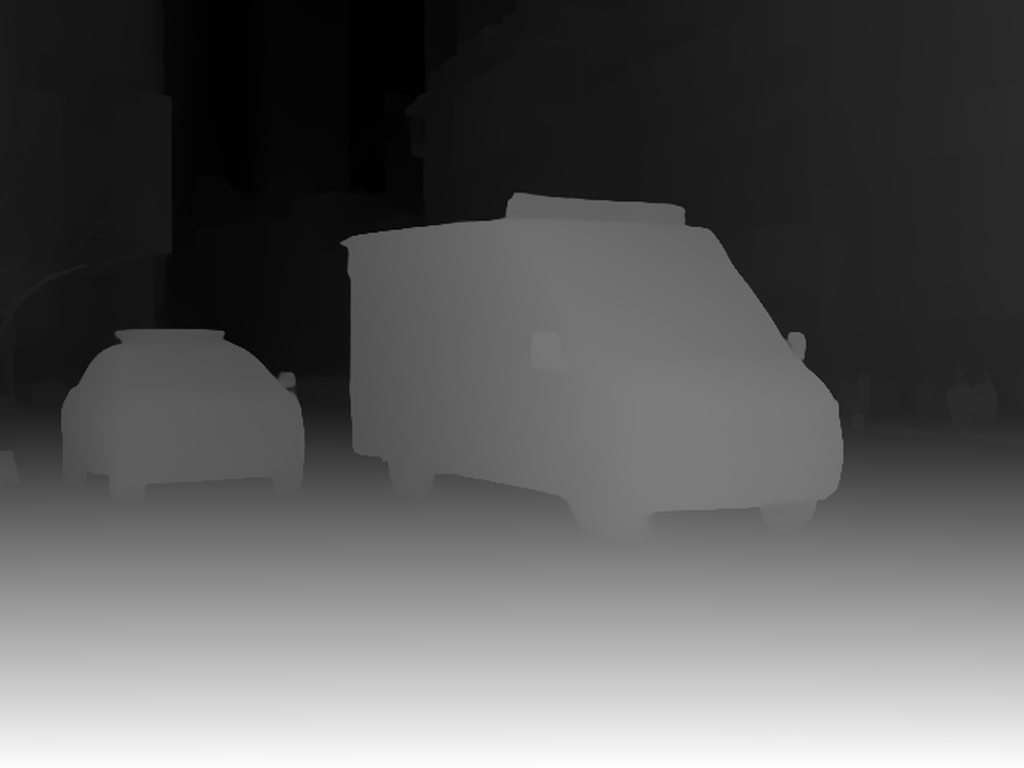

array([[ 1.9182527,  1.8868684,  1.853347 , ...,  3.115324 ,  2.9375145,
         2.7474704],
       [ 1.8908467,  1.8768076,  1.8687129, ...,  3.0972095,  3.0258849,
         2.9540162],
       [ 1.8720732,  1.8728795,  1.8853426, ...,  3.0881057,  3.1180851,
         3.1552517],
       ...,
       [19.338531 , 19.333101 , 19.335217 , ..., 19.406437 , 19.383102 ,
        19.374916 ],
       [19.4346   , 19.408678 , 19.3826   , ..., 19.48859  , 19.483383 ,
        19.464819 ],
       [19.503246 , 19.45658  , 19.405811 , ..., 19.5338   , 19.556126 ,
        19.529394 ]], dtype=float32)

In [14]:
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Base-hf")

image = generated_image

# inference
depth = pipe(image)
display(depth['depth'])
depth['predicted_depth'].numpy()